**Install Dependencies**

In [1]:
!pip install -U pandas numpy scikit-learn matplotlib scipy


**Import Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage


**Load Dataset**

In [3]:
from google.colab import files
uploaded = files.upload()   # Upload the Mall_Customers.csv file

df = pd.read_csv("Mall_Customers.csv")
df.head()


Saving Mall_Customers.csv to Mall_Customers (1).csv


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


**Exploratory Data Analysis (EDA)**

Shape: (200, 5)

Missing Values:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Descriptive Statistics:
        CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


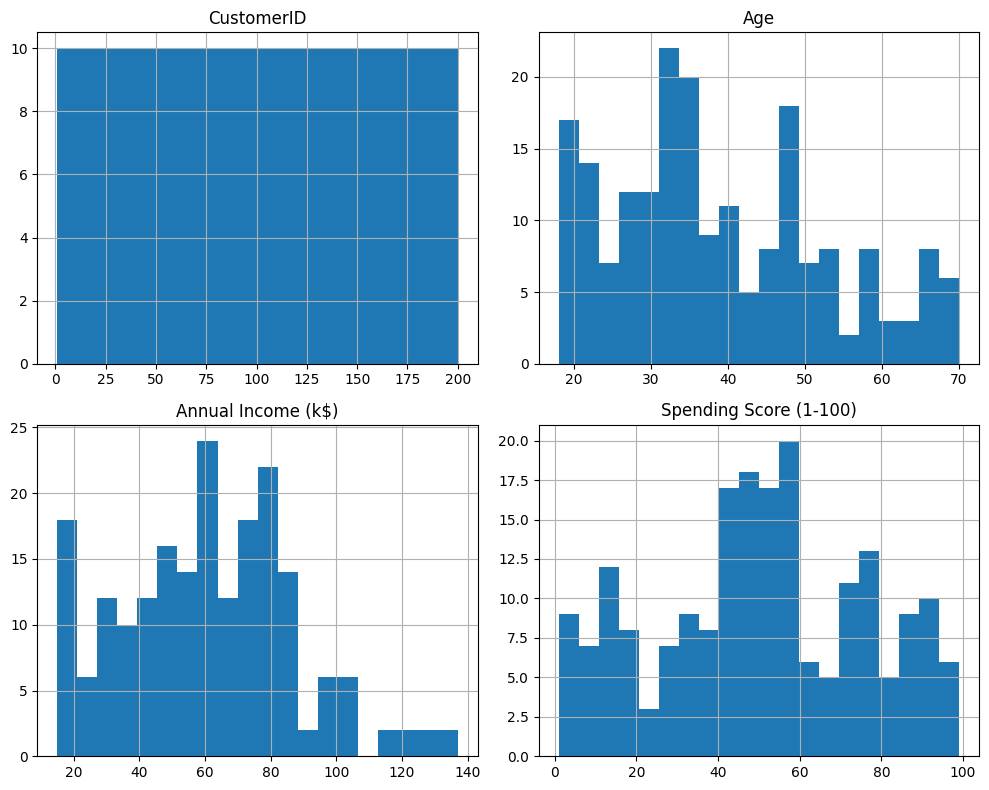

In [4]:
print("Shape:", df.shape)
print("\nMissing Values:\n", df.isna().sum())
print("\nDescriptive Statistics:\n", df.describe())

# Quick distribution plots
df.hist(figsize=(10,8), bins=20)
plt.tight_layout()
plt.show()


**Feature Selection & Scaling**

In [5]:
features = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


**Elbow Method & Silhouette Score (KMeans)**

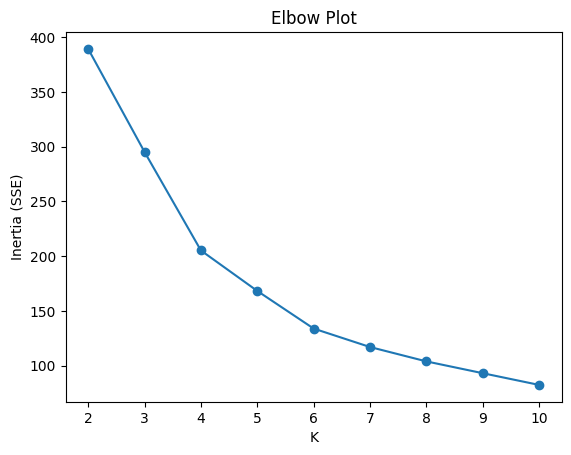

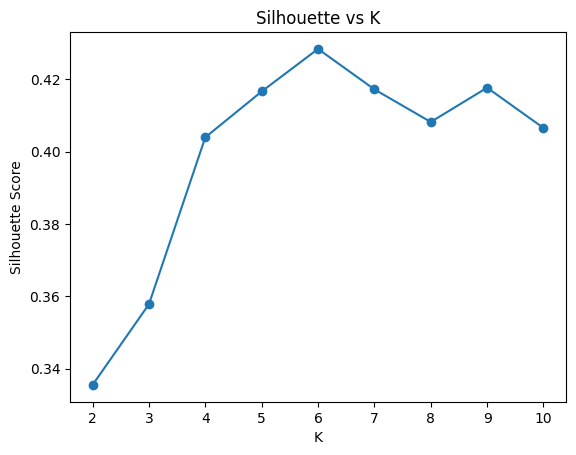

In [6]:
inertias = []
sil_scores = []
K_RANGE = range(2, 11)

for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Elbow Plot
plt.plot(K_RANGE, inertias, marker="o")
plt.xlabel("K")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Plot")
plt.show()

# Silhouette Plot
plt.plot(K_RANGE, sil_scores, marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette vs K")
plt.show()


**Final KMeans Clustering**

In [7]:
best_k = 5
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
df["KMeans_Cluster"] = kmeans.fit_predict(X_scaled)

df.groupby("KMeans_Cluster")[features].mean()


,Age,Annual Income (k$),Spending Score (1-100)
KMeans_Cluster,,,
0,46.250000,26.750000,18.350000
1,25.185185,41.092593,62.240741
2,32.875000,86.100000,81.525000
3,39.871795,86.102564,19.358974
4,55.638298,54.382979,48.851064


**Hierarchical Clustering & Dendrogram**

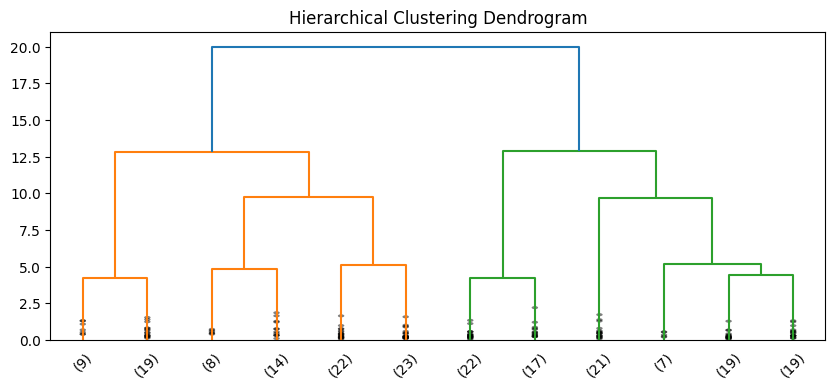

In [8]:
agglo = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
df["HClust_Cluster"] = agglo.fit_predict(X_scaled)

# Dendrogram
Z = linkage(X_scaled, method="ward")
plt.figure(figsize=(10,4))
dendrogram(Z, truncate_mode="lastp", p=12, leaf_rotation=45, leaf_font_size=10, show_contracted=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()


**PCA for Visualization**

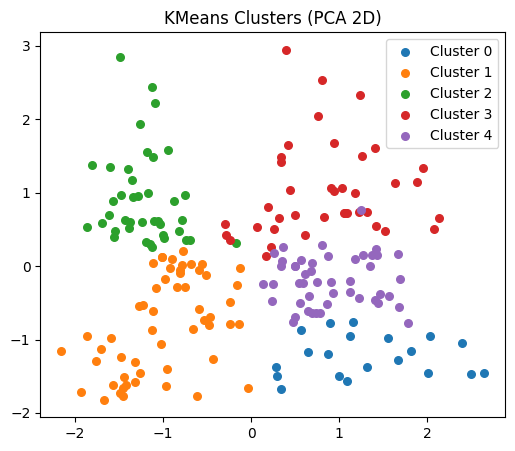

In [9]:
pca = PCA(n_components=2, random_state=42)
pts2d = pca.fit_transform(X_scaled)
df["PC1"], df["PC2"] = pts2d[:,0], pts2d[:,1]

plt.figure(figsize=(6,5))
for c in sorted(df["KMeans_Cluster"].unique()):
    subset = df[df["KMeans_Cluster"] == c]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {c}", s=30)
plt.legend()
plt.title("KMeans Clusters (PCA 2D)")
plt.show()

**Business Insights**

In [10]:
median_income = df["Annual Income (k$)"].median()
median_spend = df["Spending Score (1-100)"].median()
median_age = df["Age"].median()

insights = []
for cid, grp in df.groupby("KMeans_Cluster"):
    size = len(grp)
    inc, spend, age = grp["Annual Income (k$)"].mean(), grp["Spending Score (1-100)"].mean(), grp["Age"].mean()

    tags = []
    tags.append("High Income" if inc >= median_income else "Low Income")
    tags.append("High Spend" if spend >= median_spend else "Low Spend")
    tags.append("Younger" if age <= median_age else "Older")

    insights.append({
        "Cluster": cid,
        "Size": size,
        "Mean_Age": round(age,2),
        "Mean_Income(k$)": round(inc,2),
        "Mean_SpendingScore": round(spend,2),
        "Tags": ", ".join(tags)
    })

pd.DataFrame(insights)


,Cluster,Size,Mean_Age,Mean_Income(k$),Mean_SpendingScore,Tags
0,0,20,46.25,26.75,18.35,"Low Income, Low Spend, Older"
1,1,54,25.19,41.09,62.24,"Low Income, High Spend, Younger"
2,2,40,32.88,86.10,81.53,"High Income, High Spend, Younger"
3,3,39,39.87,86.10,19.36,"High Income, Low Spend, Older"
4,4,47,55.64,54.38,48.85,"Low Income, Low Spend, Older"
